<a href="https://colab.research.google.com/github/remanx2558/MIDBReviews/blob/master/FastText_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/My Drive

[Errno 2] No such file or directory: '/content/drive/My Drive'
/content


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ls

In [0]:
import os
import sys
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from gensim.models import KeyedVectors

In [9]:
import pandas as pd
import numpy as np


movie_reviews = pd.read_csv(r"/content/drive/My Drive/malia/train.csv")

movie_reviews.isnull().values.any()
movie_reviews.sentiment= movie_reviews.sentiment.fillna(0.0).astype(int)#this will conver float into int and also manage missing values

movie_reviews.shape



(25005, 2)

In [0]:


def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence



In [0]:
import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)


In [0]:
reviews = []
sentences = list(movie_reviews['text'])
for sen in sentences:
    reviews.append(preprocess_text(sen))



In [0]:
movie_reviews['text'] = reviews

In [66]:
tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(movie_reviews['text'])
sequences = tokenizer.texts_to_sequences(movie_reviews['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

MAX_SEQUENCE_LENGTH = 1000

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 34043 unique tokens.
Shape of data tensor: (25005, 1000)
Shape of label tensor: (25005, 2)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(data, labels, test_size=0.5, random_state=42)


In [68]:
!wget https://drive.google.com/open?id=1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq

--2020-06-14 08:11:05--  https://drive.google.com/open?id=1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq
Resolving drive.google.com (drive.google.com)... 172.217.193.139, 172.217.193.113, 172.217.193.138, ...
Connecting to drive.google.com (drive.google.com)|172.217.193.139|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://drive.google.com/file/d/1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq/view?usp=drive_open [following]
--2020-06-14 08:11:05--  https://drive.google.com/file/d/1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq/view?usp=drive_open
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘open?id=1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq.2’

open?id=1xzt06g_xeP     [ <=>                ]  68.22K  --.-KB/s    in 0.001s  

2020-06-14 08:11:05 (73.0 MB/s) - ‘open?id=1xzt06g_xeP1DitFXhJprF5VTwzNEUYhq.2’ saved [69858]



In [0]:
model_ft = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec', binary=False)

In [69]:
EMBEDDING_DIM = 300
MAX_NUM_WORDS=500
print('Preparing embedding matrix.fast text')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    if word in model_ft.vocab:
      embedding_vector = model_ft[word]
      embedding_vector = np.array(embedding_vector)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

Preparing embedding matrix.fast text
(500, 300)


In [70]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import Flatten
from keras.initializers import Constant

print('Training model.')

# define the model
model = Sequential()
model.add(Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# summarize the model
print(model.summary())

model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          validation_data=(x_train, y_train))

Training model.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 300)         150000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 300000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               153600512 
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 153,914,994
Trainable params: 153,764,994
Non-trainable params: 150,000
__________________

In [71]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))

Accuracy: 0.860182
Loss: 0.350142


In [0]:
#model.most_similar(positive="dinner")
#from keras.preprocessing.text import Tokenizer
model.save_weights("model.h5")


In [0]:
from keras.preprocessing.text import text_to_word_sequence
import keras

In [0]:
reviews = [ str(r) for r in movie_reviews['text'].values]
labels = movie_reviews['sentiment'].values

for idx, review in enumerate(movie_reviews):
    words = text_to_word_sequence(review)
    if(len(words) > 40): 
        words = words[:40]
        movie_reviews[idx] = ' '.join(words)

oneHotReviews = tokenizer.texts_to_sequences(reviews)
encodedReviews = keras.preprocessing.sequence.pad_sequences(oneHotReviews, maxlen=40, padding='post')

X_train, X_test, y_train, y_test = train_test_split(encodedReviews, labels, test_size=0.33, random_state=42)

In [76]:
from tensorflow.keras.layers import Bidirectional,Conv1D,LSTM,MaxPooling1D,Dropout
from tensorflow.keras.layers import Dense,Input,Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from tensorflow.keras import backend
maxlen=40
max_features=40000
batch_size=32

print('Pad sequences (samples x time)')
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Pad sequences (samples x time)
X_train shape: (16753, 40)
X_test shape: (8252, 40)


In [78]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 128)           5120000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 5,218,945
Trainable params: 5,218,945
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
history=model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=5,
          validation_data=[X_test, y_test])


Epoch 1/5
524/524 [==============================] - 35s 67ms/step - loss: 0.5935 - accuracy: 0.6700 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
524/524 [==============================] - 35s 67ms/step - loss: 0.5437 - accuracy: 0.7152 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/5
524/524 [==============================] - 35s 66ms/step - loss: 0.5302 - accuracy: 0.7236 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/5
524/524 [==============================] - 35s 67ms/step - loss: 0.5188 - accuracy: 0.7325 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/5
524/524 [==============================] - 35s 66ms/step - loss: 0.5073 - accuracy: 0.7394 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [80]:
 loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(accuracy))

258/258 [==============================] - 1s 5ms/step - loss: 0.5442 - accuracy: 0.7204
Test Loss: 0.5442385077476501
Test Accuracy: 0.720431387424469


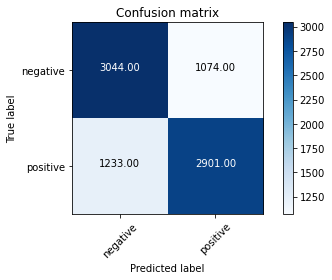

In [81]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import tensorflow.contrib.keras as keras
import matplotlib.pyplot as plt
import os
import sys
import pickle
import itertools
import gensim
from sklearn.model_selection import train_test_split
from numpy import zeros
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec
predictions = model.predict_classes(X_test)

cm = confusion_matrix(y_test, predictions, labels=[0,1])
title = 'Confusion matrix'
cmap = plt.cm.Blues
classes=["negative","positive"]
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [82]:
report = classification_report(y_test, predictions, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.71      0.74      0.73      4118
           1       0.73      0.70      0.72      4134

    accuracy                           0.72      8252
   macro avg       0.72      0.72      0.72      8252
weighted avg       0.72      0.72      0.72      8252

